# Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter

import humanize
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection
import skimage
from skimage import measure, io
import pandas as pd
import seaborn as sns
import pandas as pd

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, Volume, EstimationVolume, SetPartition
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz
from tomo2seg.logger import logger

In [3]:
from tomo2seg.data import VOLUME_PRECIPITATES_V1 as VOL_NAME_VERSION
logger.debug(f"{VOL_NAME_VERSION=}")

In [4]:
logger.setLevel(logging.DEBUG)

In [5]:
random_state = 42
random_state = np.random.RandomState(random_state)

# Load from the disk

In [6]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    volume_name := VOL_NAME_VERSION[0], 
    volume_version := VOL_NAME_VERSION[1]
)
logger.info(f"{volume=}")

hst_read = lambda x, **kwargs: functools.partial(
    # from pymicro
    file_utils.HST_read,
    # pre-loaded kwargs
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
)(str(x), **kwargs)  # it doesn't accept paths...

[2020-11-13::15:06:35.576] tomo2seg :: DEBUG :: {data.py:with_check:214}
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

[2020-11-13::15:06:35.603] tomo2seg :: ERROR :: {data.py:with_check:232}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels.raw

[2020-11-13::15:06:35.620] tomo2seg :: WARNING :: {data.py:with_check:236}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.weights.raw

[2020-11-13::15:06:35.621] tomo2seg :: DEBUG :: {data.py:metadata:171}
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

[2020-11-13::15:06:35.635] tomo2seg :: INFO :: {<ipython-input-6-c82915dcb1eb>:<module>:008}
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1299], 'y_range': [0

# Porosity blobs

In [7]:
filename = volume.blobs3d_props_path(class_idx=2, labels_version="refined")  # 2 = porosity
logger.debug(f"{filename=}")

astype_map = {"area": int, "centroid-0": int, "centroid-1": int, "centroid-2": int}
rename_map = {
    "Unnamed: 0": "index", 
    "centroid-0": "centroid-x", "centroid-1": "centroid-y", "centroid-2": "centroid-z",
    "local_centroid-0": "local_centroid-x", "local_centroid-1": "local_centroid-y", "local_centroid-2": "local_centroid-z",
}
blobsdf = pd.read_csv(filename).astype(astype_map).rename(columns=rename_map).set_index("index")

logger.debug(f"{blobsdf.shape}")

blobsdf.loc[blobsdf.minor_axis_length == 0, "minor_axis_length"] = 1
blobsdf["aspect_ratio"] = blobsdf.major_axis_length / blobsdf.minor_axis_length

blacklist = np.zeros(blobsdf.shape[0]).astype(bool)

[2020-11-13::15:06:35.730] tomo2seg :: DEBUG :: {<ipython-input-7-834f4fa9797f>:<module>:002}
filename=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels-refined.blobs3d.props.class_idx=2.csv')

[2020-11-13::15:06:39.042] tomo2seg :: DEBUG :: {<ipython-input-7-834f4fa9797f>:<module>:012}
(263116, 94)



In [8]:
cols_no_moments = [c for c in blobsdf.columns if "moments_central" not in c and c != "slice"]
cols_no_moments_only_diag_inertia = [c for c in blobsdf.columns if "moments_central" not in c and ("inertia_tensor" not in c or c[-1] == c[-3]) and c != "slice"]
cols_no_moments_no_inertia = [c for c in blobsdf.columns if "moments_central" not in c and "inertia_tensor" not in c and c != "slice"]
cols_no_moments_no_inertia_no_bbox = [c for c in blobsdf.columns if "moments_central" not in c and "inertia_tensor" not in c and "bbox-" not in c and c != "slice"]

In [9]:
pd.set_option("display.max_rows", 100)

In [10]:
blobsdf[cols_no_moments_no_inertia_no_bbox].describe().T

,count,mean,std,min,25%,50%,75%,max
label,263116.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000,2.000000e+00
area,263116.0,49.091758,184.860614,1.000000,5.000000,12.000000,37.000,2.833300e+04
bbox_area,263116.0,405.205012,11525.063332,1.000000,6.000000,24.000000,126.000,5.475800e+06
extent,263116.0,0.539877,0.290124,0.000729,0.295000,0.500000,0.750,1.000000e+00
filled_area,263116.0,49.092571,184.901685,1.000000,5.000000,12.000000,37.000,2.835000e+04
centroid-x,263116.0,698.715312,363.943559,0.000000,418.000000,693.000000,1013.000,1.299000e+03
centroid-y,263116.0,518.724072,301.958462,0.000000,256.000000,514.000000,778.000,1.039000e+03
centroid-z,263116.0,920.021846,555.813318,0.000000,440.000000,883.000000,1403.000,1.899000e+03
local_centroid-x,263116.0,1.388412,1.644257,0.000000,0.500000,1.000000,1.750,6.690000e+01
local_centroid-y,263116.0,3.463320,5.029559,0.000000,1.000000,1.889000,4.050,1.375000e+02


# Cut off tiny blobs

In [11]:
blobs_area_threshold = 3

blacklist |= blobsdf.area <= blobs_area_threshold

In [12]:
blobsdf.loc[~blacklist, cols_no_moments_no_inertia_no_bbox].describe().T

,count,mean,std,min,25%,50%,75%,max
label,217593.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
area,217593.0,58.860818,201.918950,4.000000,7.000000,16.000000,47.000000,2.833300e+04
bbox_area,217593.0,489.393156,12671.828038,4.000000,12.000000,40.000000,180.000000,5.475800e+06
extent,217593.0,0.461517,0.247468,0.000729,0.265000,0.416700,0.666500,1.000000e+00
filled_area,217593.0,58.861802,201.964370,4.000000,7.000000,16.000000,47.000000,2.835000e+04
centroid-x,217593.0,700.733443,369.092311,0.000000,410.000000,698.000000,1023.000000,1.299000e+03
centroid-y,217593.0,520.027285,300.387754,0.000000,261.000000,516.000000,777.000000,1.039000e+03
centroid-z,217593.0,925.764069,558.743632,0.000000,442.000000,891.000000,1416.000000,1.899000e+03
local_centroid-x,217593.0,1.633474,1.703776,0.000000,0.678700,1.187500,2.000000,6.690000e+01
local_centroid-y,217593.0,4.079155,5.326126,0.000000,1.300000,2.459000,4.707000,1.375000e+02


# area x aspect_ratio

CPU times: user 22.1 s, sys: 663 ms, total: 22.8 s
Wall time: 22.8 s


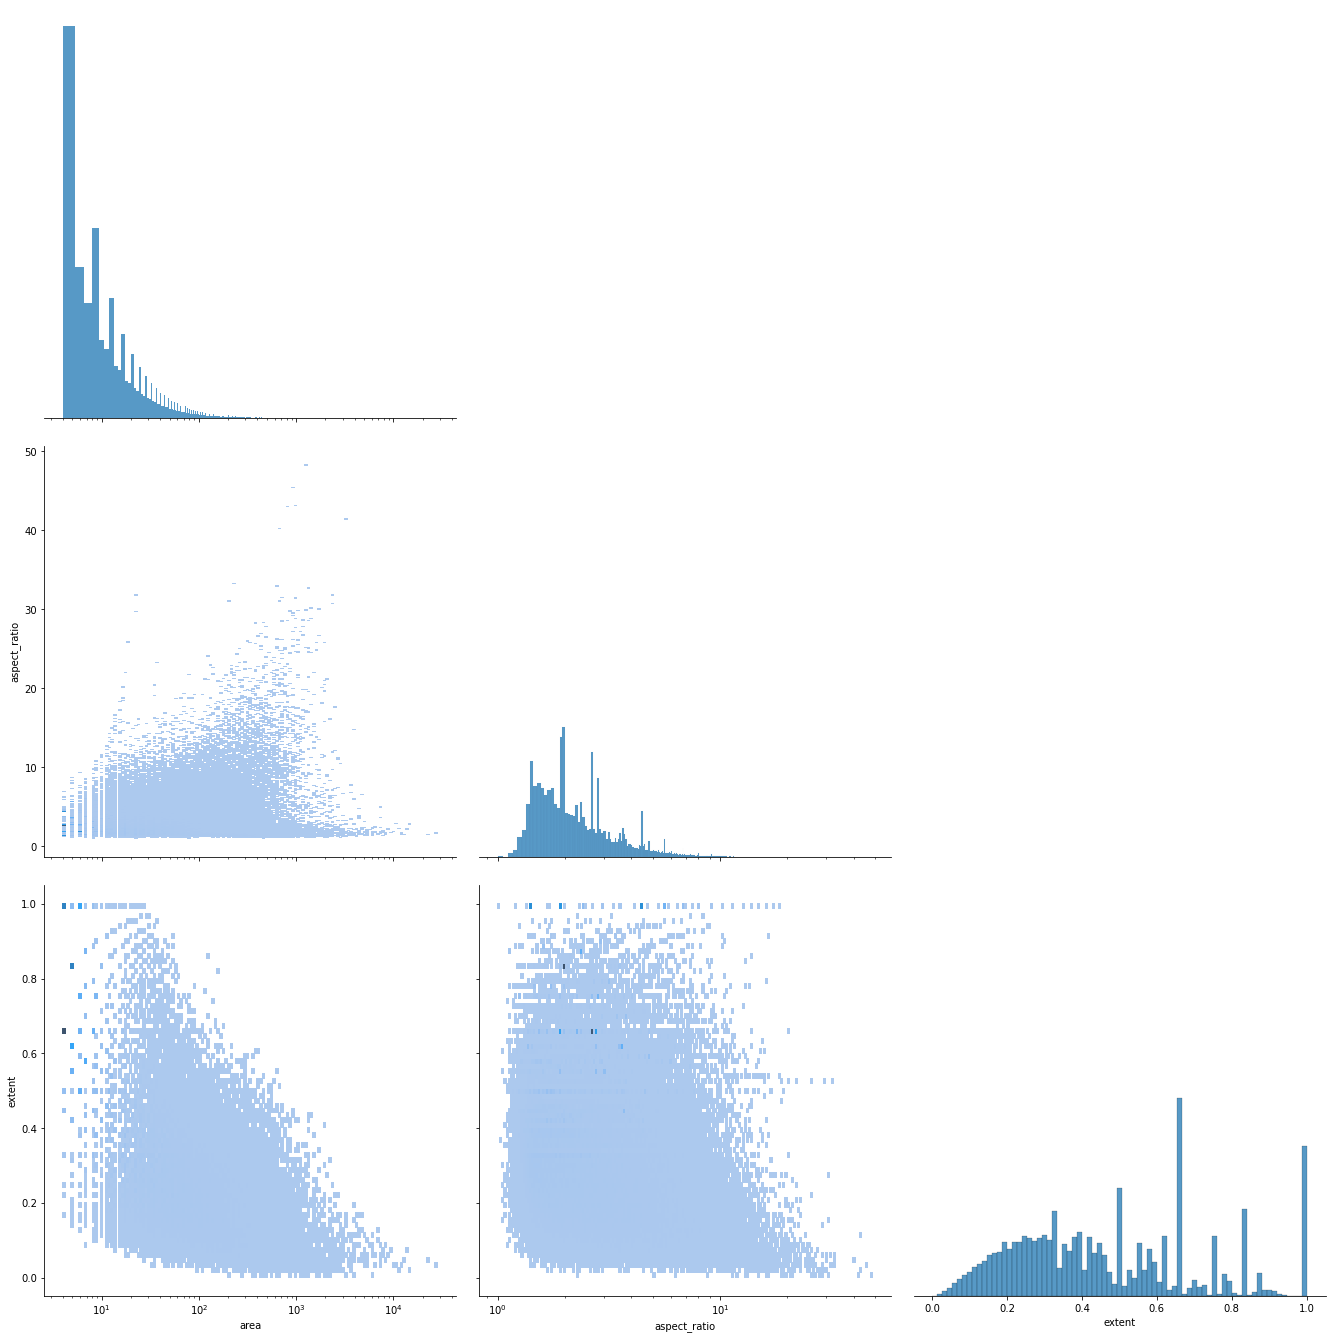

In [13]:
%%time
n = None
df = blobsdf[~blacklist]
df = df.iloc[:n] if n is not None else df

pairgrid = sns.pairplot(
    df,
    vars=["area", "aspect_ratio", "extent"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(True, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 20, sz))

# Checking examples

In [14]:
from IPython.display import display

def show(selector, bbox=False):
    global blacklist, blobsdf, cols_no_moments_no_inertia_no_bbox, cols_no_moments_no_inertias
    select = (~blacklist) & selector
    logger.info(f"Found {int(select.sum())} blobs.")
    display(blobsdf[select][cols_no_moments_no_inertia_no_bbox if not bbox else cols_no_moments_no_inertia])
    return select

## `extent` == 1

In [76]:
show((blobsdf.extent == 1) & (blobsdf.area > 20));

[2020-11-13::10:13:41.805] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 12 blobs.



,label,area,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,
54963,2,27,27,1.0,27,345,633,823,1.0,4.0,0.0,10.836,3.266,"(slice(344, 347, None), slice(629, 638, None),...",54964,3.317820
69766,2,24,24,1.0,24,441,1008,1089,0.5,5.5,0.0,13.950,2.000,"(slice(441, 443, None), slice(1003, 1015, None...",69767,6.975000
69931,2,21,21,1.0,21,443,999,529,1.0,3.0,0.0,8.640,3.266,"(slice(442, 445, None), slice(996, 1003, None)...",69932,2.645438
173452,2,21,21,1.0,21,891,676,346,1.0,3.0,0.0,8.640,3.266,"(slice(890, 893, None), slice(673, 680, None),...",173453,2.645438
218267,2,21,21,1.0,21,1111,225,1512,1.0,3.0,0.0,8.640,3.266,"(slice(1110, 1113, None), slice(222, 229, None...",218268,2.645438
222580,2,24,24,1.0,24,1130,441,1884,0.5,2.5,0.5,7.117,2.828,"(slice(1130, 1132, None), slice(439, 445, None...",222581,2.516620
247176,2,22,22,1.0,22,1232,835,893,0.5,5.0,0.0,12.805,2.000,"(slice(1232, 1234, None), slice(830, 841, None...",247177,6.402500
250121,2,21,21,1.0,21,1245,877,801,1.0,3.0,0.0,8.640,3.266,"(slice(1244, 1247, None), slice(874, 881, None...",250122,2.645438
250729,2,26,26,1.0,26,1248,376,1763,0.5,6.0,0.0,15.100,2.000,"(slice(1247, 1249, None), slice(370, 383, None...",250730,7.550000


## `extent` close to zero

In [91]:
threshold = .012
show((blobsdf.extent < threshold), bbox=False);

[2020-11-13::11:12:38.459] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 15 blobs.



,label,area,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,
0,2,3991,5475800,0.000729,3991,4,27,637,4.555,27.67,637.500,1974.00,134.000,"(slice(0, 22, None), slice(0, 131, None), slic...",1,14.731343
110,2,1930,175560,0.010994,1930,8,534,643,8.530,89.10,30.770,183.80,9.375,"(slice(0, 19, None), slice(445, 610, None), sl...",111,19.605333
4002,2,2009,221487,0.009070,2009,34,455,958,10.060,97.80,23.300,226.80,10.810,"(slice(24, 45, None), slice(358, 557, None), s...",4003,20.980574
10282,2,1627,140244,0.011604,1627,75,91,426,12.700,73.00,10.340,202.90,7.870,"(slice(63, 92, None), slice(18, 204, None), sl...",10283,25.781449
10809,2,503,44132,0.011400,503,72,406,913,6.750,41.56,7.380,128.90,6.760,"(slice(66, 83, None), slice(365, 483, None), s...",10810,19.068047
24044,2,3182,756756,0.004204,3182,164,674,195,18.980,132.00,29.500,335.80,8.100,"(slice(145, 184, None), slice(542, 836, None),...",24045,41.456790
27125,2,1995,373756,0.005337,1995,182,240,456,18.860,78.25,22.950,207.80,8.050,"(slice(164, 205, None), slice(162, 334, None),...",27126,25.813665
29147,2,686,101525,0.006756,686,190,139,815,13.790,66.06,15.930,156.00,5.027,"(slice(177, 202, None), slice(73, 204, None), ...",29148,31.032425
130125,2,6204,694848,0.008930,6204,722,738,1540,34.560,71.00,56.900,139.20,60.400,"(slice(688, 754, None), slice(667, 779, None),...",130126,2.304636


### Blob id==1

In [98]:
show((blobsdf.id == 1), bbox=True);

[2020-11-13::11:34:47.483] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 1 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,,,,,,,
0,2,3991,0,0,0,22,131,1900,5475800,0.000729,3991,4,27,637,4.555,27.67,637.5,1974.0,134.0,"(slice(0, 22, None), slice(0, 131, None), slic...",1,14.731343


In [36]:
sl = blobsdf[blobsdf.id == 1].slice[0]
sl

'(slice(0, 22, None), slice(0, 131, None), slice(0, 1900, None))'

In [57]:
blobs_volume = hst_read(volume.blobs3d_volume_path(2, "refined"), data_type=np.int32)

data type is <class 'numpy.int32'>
volume size is 1300 x 1040 x 1900
reading volume... from byte 0


In [62]:
blob = (blobs_volume == 1).astype(int)[0:22, 0:131, 0:1900]

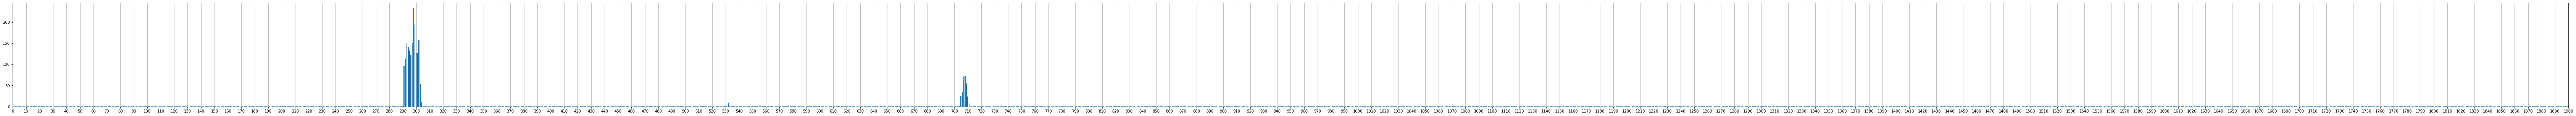

In [90]:
plt.figure(figsize=(24* (sz := 5), sz))
plt.bar(range(1900),blob.sum(axis=0).sum(axis=0))
plt.xticks(np.linspace(0, 1900, 191));
plt.xlim(0, 1900)
plt.grid(which='both', axis='x')

### Others

In [100]:
show((blobsdf.id == 111), bbox=True);

[2020-11-13::11:34:58.658] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 1 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,,,,,,,
110,2,1930,0,445,612,19,610,668,175560,0.010994,1930,8,534,643,8.53,89.1,30.77,183.8,9.375,"(slice(0, 19, None), slice(445, 610, None), sl...",111,19.605333


In [101]:
show((blobsdf.id == 4003), bbox=True);

[2020-11-13::11:35:00.739] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 1 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,,,,,,,
4002,2,2009,24,358,935,45,557,988,221487,0.00907,2009,34,455,958,10.06,97.8,23.3,226.8,10.81,"(slice(24, 45, None), slice(358, 557, None), s...",4003,20.980574


## high `aspect_ratio` 

In [103]:
threshold = 30
show((blobsdf.aspect_ratio > threshold), bbox=True);

[2020-11-13::11:41:44.564] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 18 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,,,,,,,
1903,2,2374,10,724,544,23,976,563,62244,0.038150,2374,15,861,553,5.1200,137.50,9.290,269.20,8.460,"(slice(10, 23, None), slice(724, 976, None), s...",1904,31.820331
4664,2,646,28,521,148,34,658,160,9864,0.065500,646,30,593,153,2.2460,72.56,5.074,144.20,4.375,"(slice(28, 34, None), slice(521, 658, None), s...",4665,32.960000
24044,2,3182,145,542,166,184,836,232,756756,0.004204,3182,164,674,195,18.9800,132.00,29.500,335.80,8.100,"(slice(145, 184, None), slice(542, 836, None),...",24045,41.456790
29147,2,686,177,73,799,202,204,830,101525,0.006756,686,190,139,815,13.7900,66.06,15.930,156.00,5.027,"(slice(177, 202, None), slice(73, 204, None), ...",29148,31.032425
161218,2,837,826,855,1826,837,1024,1858,59488,0.014070,837,830,930,1841,4.5500,75.56,15.080,199.40,4.637,"(slice(826, 837, None), slice(855, 1024, None)...",161219,43.001941
163890,2,652,841,619,1519,846,761,1538,13490,0.048340,652,842,691,1528,1.4600,72.44,8.805,162.10,4.027,"(slice(841, 846, None), slice(619, 761, None),...",163891,40.253290
199478,2,205,1022,596,566,1025,680,569,756,0.271200,205,1022,629,567,0.6540,33.25,1.034,92.80,2.990,"(slice(1022, 1025, None), slice(596, 680, None...",199479,31.036789
213772,2,702,1088,747,1718,1103,871,1729,20460,0.034300,702,1095,807,1722,6.6700,60.44,4.414,147.10,4.670,"(slice(1088, 1103, None), slice(747, 871, None...",213773,31.498929
220998,2,237,1123,252,705,1133,340,713,7040,0.033660,237,1127,296,708,4.1950,44.34,3.578,103.30,3.110,"(slice(1123, 1133, None), slice(252, 340, None...",220999,33.215434


In [106]:
show((blobsdf.id == 245023), bbox=True);

[2020-11-13::11:43:53.256] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 1 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,,,,,,,
245022,2,23,1224,483,958,1226,505,959,44,0.523,23,1225,493,958,0.9565,10.22,0.0,25.39,0.798,"(slice(1224, 1226, None), slice(483, 505, None...",245023,31.817043


In [107]:
show((blobsdf.id == 24045), bbox=True);

[2020-11-13::11:47:06.090] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 1 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,,,,,,,
24044,2,3182,145,542,166,184,836,232,756756,0.004204,3182,164,674,195,18.98,132.0,29.5,335.8,8.1,"(slice(145, 184, None), slice(542, 836, None),...",24045,41.45679


In [108]:
show((blobsdf.id == 29148), bbox=True);

[2020-11-13::11:53:34.159] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 1 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,,,,,,,
29147,2,686,177,73,799,202,204,830,101525,0.006756,686,190,139,815,13.79,66.06,15.93,156.0,5.027,"(slice(177, 202, None), slice(73, 204, None), ...",29148,31.032425


## big `area` 

In [113]:
threshold = 8 * 10**3
show((blobsdf.area > threshold));

[2020-11-13::12:10:34.454] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 14 blobs.



,label,area,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,
93676,2,22728,446832,0.05087,22728,639,356,703,60.34,50.28,21.73,125.56,85.56,"(slice(579, 686, None), slice(306, 393, None),...",93677,1.467508
95273,2,9833,258552,0.03802,9833,615,333,342,28.50,40.53,21.73,102.80,54.90,"(slice(587, 663, None), slice(293, 374, None),...",95274,1.872495
97589,2,8317,175104,0.04750,8317,632,420,1155,34.40,28.92,17.42,75.30,45.72,"(slice(598, 674, None), slice(391, 455, None),...",97590,1.646982
98926,2,11911,349888,0.03403,11911,645,410,671,40.94,46.60,40.20,93.70,63.72,"(slice(604, 681, None), slice(364, 435, None),...",98927,1.470496
102613,2,11537,455715,0.02531,11537,663,380,381,43.94,43.25,32.10,115.60,52.38,"(slice(619, 684, None), slice(337, 460, None),...",102614,2.206949
103017,2,8863,155610,0.05695,8863,660,979,1479,40.03,19.50,21.17,85.70,40.06,"(slice(620, 690, None), slice(960, 999, None),...",103018,2.139291
106847,2,28333,711048,0.03986,28350,673,473,664,40.22,37.62,50.44,142.80,87.80,"(slice(633, 711, None), slice(436, 522, None),...",106848,1.626424
108064,2,13567,197456,0.06870,13567,667,145,593,30.06,43.53,17.62,95.50,44.53,"(slice(637, 693, None), slice(102, 184, None),...",108065,2.144622
112762,2,9238,131440,0.07030,9238,671,869,1621,22.81,29.22,31.95,72.90,40.90,"(slice(648, 688, None), slice(840, 893, None),...",112763,1.782396


In [116]:
show((blobsdf.id == 100622), bbox=True);

[2020-11-13::12:10:59.089] tomo2seg :: INFO :: {<ipython-input-73-3853211ed0f6>:show:006}
Found 1 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,major_axis_length,minor_axis_length,slice,id,aspect_ratio
index,,,,,,,,,,,,,,,,,,,,,,
100621,2,1307,611,449,1566,626,465,1579,3120,0.419,1307,618,456,1572,7.273,7.773,6.105,18.48,16.61,"(slice(611, 626, None), slice(449, 465, None),...",100622,1.112583


# Inertia Tensor

CPU times: user 6.78 s, sys: 206 ms, total: 6.98 s
Wall time: 6.99 s


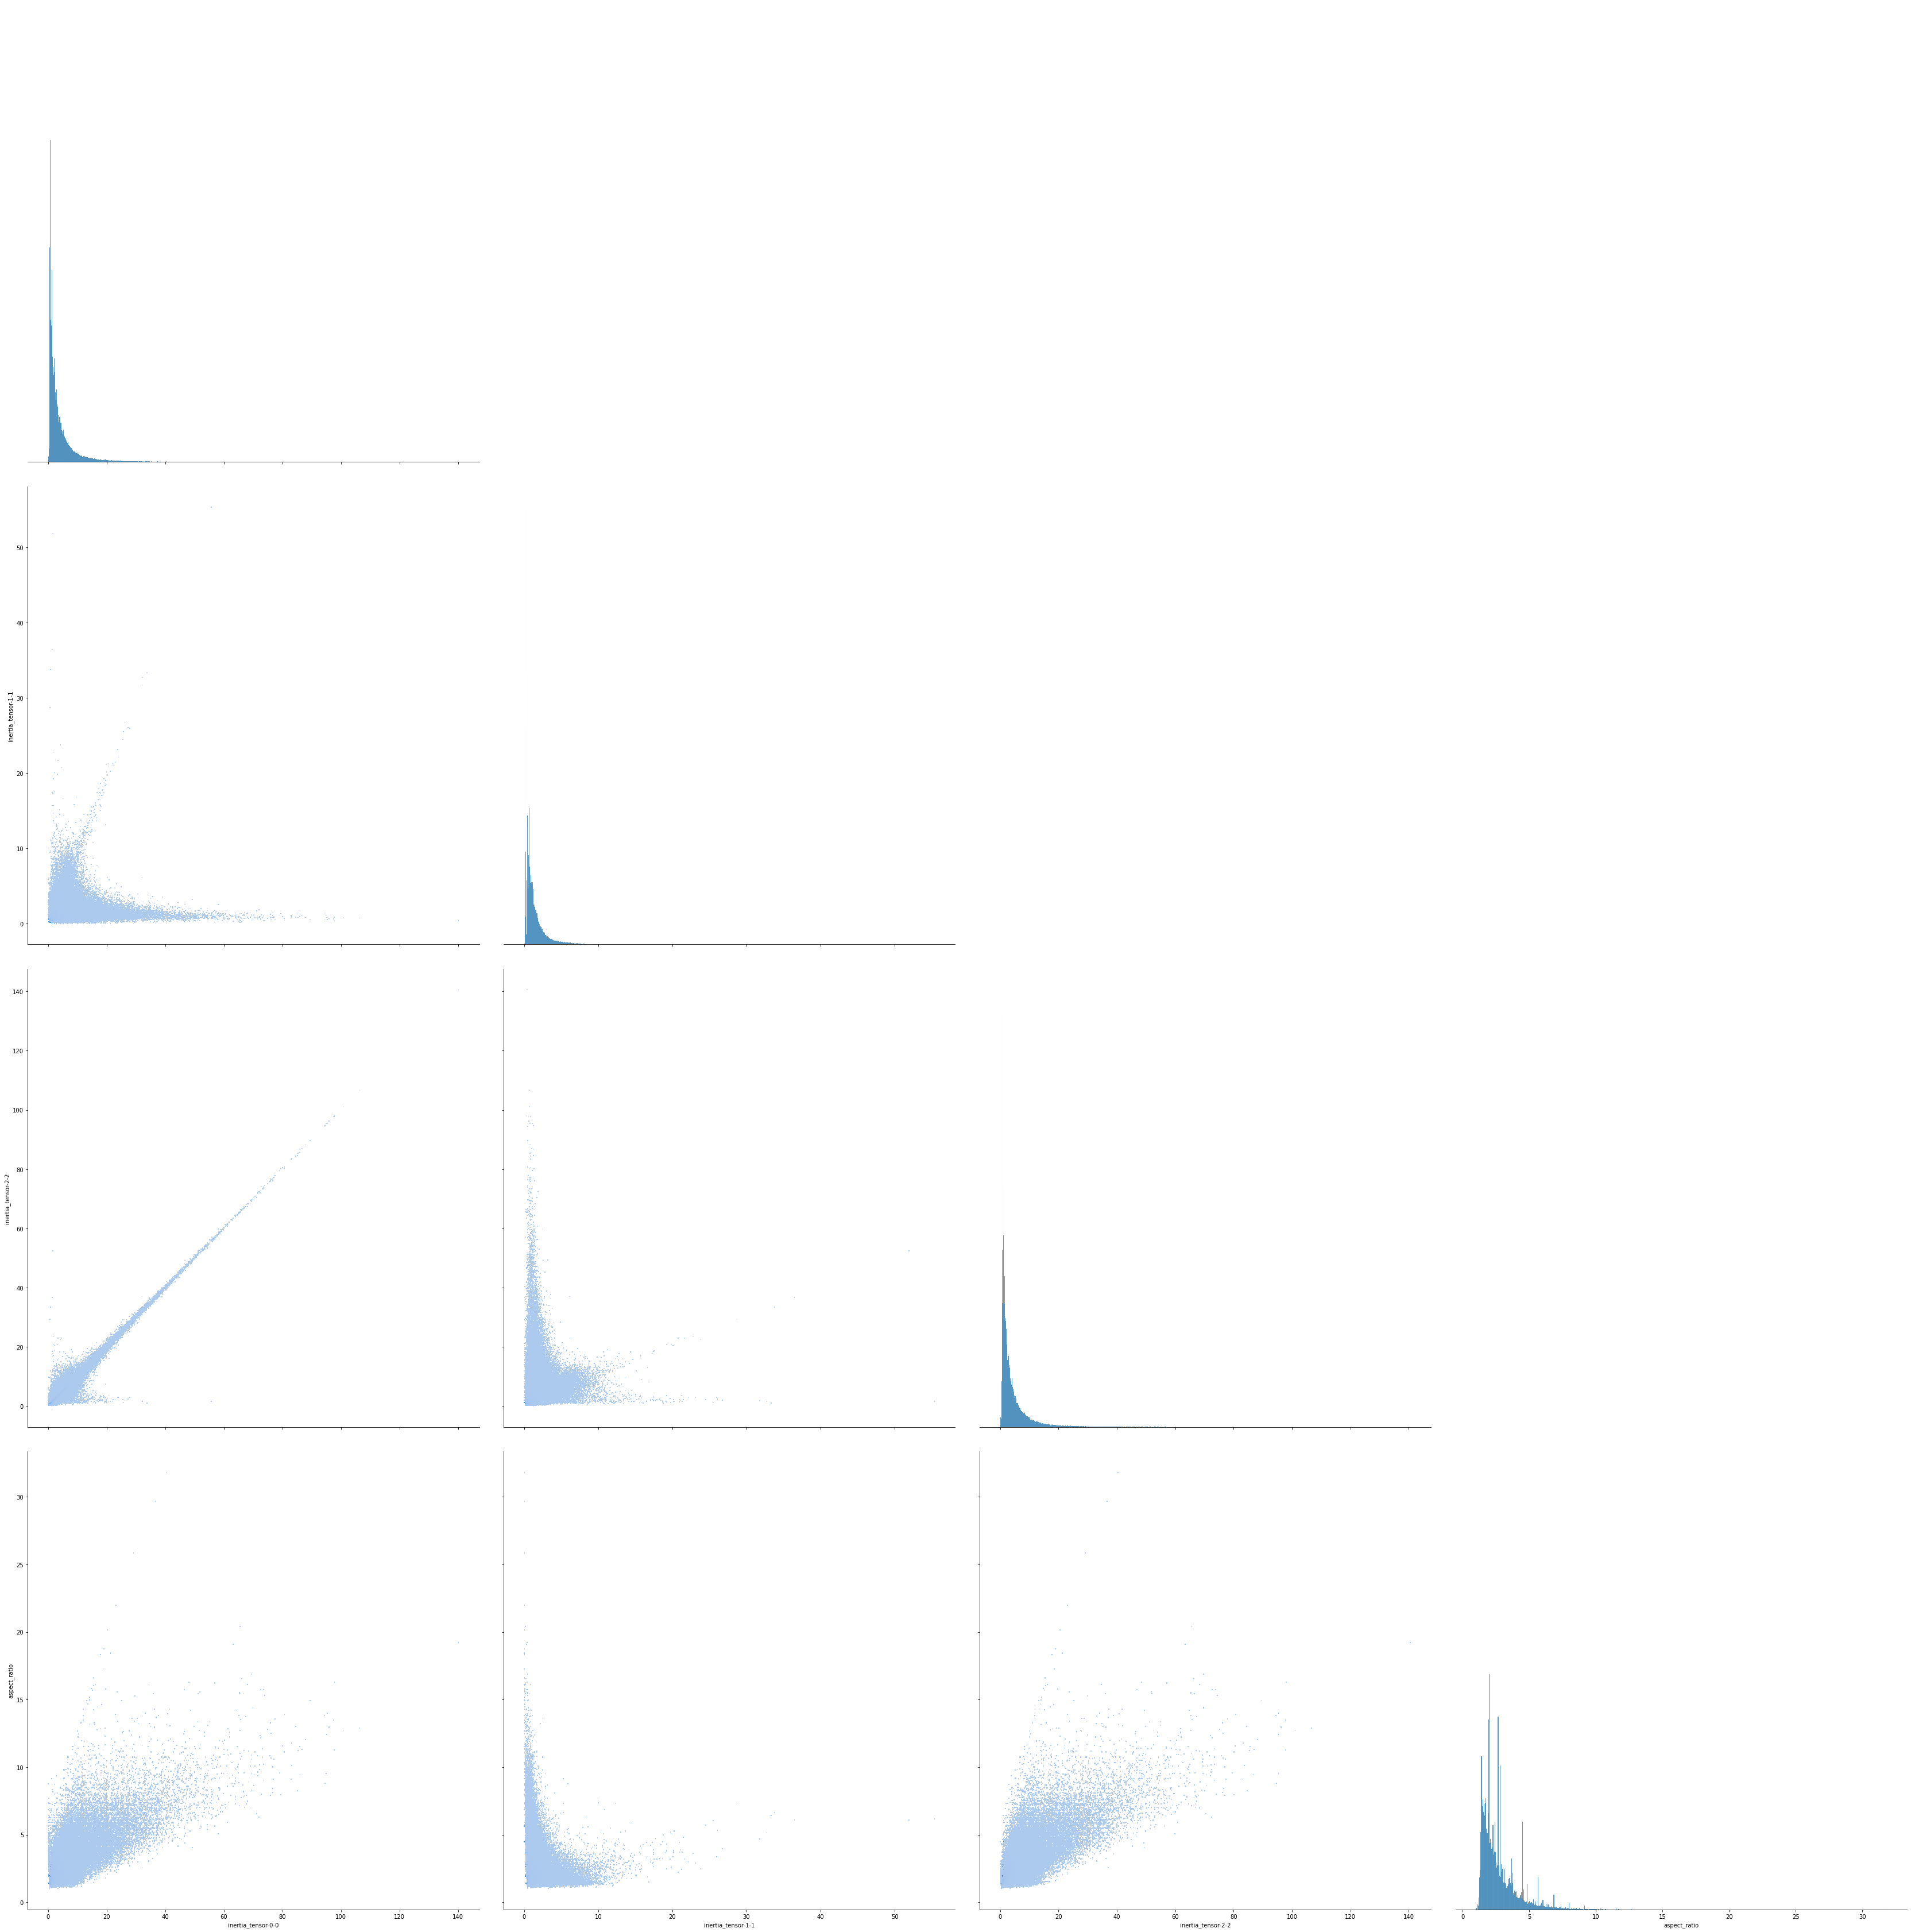

In [135]:
%%time
n = None
df = blobsdf[~blacklist]
df = df.iloc[:n] if n is not None else df
df = df.replace([np.inf, -np.inf], np.nan).dropna()

pairgrid = sns.pairplot(
    df,
    vars=["inertia_tensor-0-0", "inertia_tensor-1-1", "inertia_tensor-2-2", "aspect_ratio"],
#     vars=["relative_inertia_tensor-0-0", "relative_inertia_tensor-1-1", "relative_inertia_tensor-2-2", "aspect_ratio"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(False, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 50, sz))

In [147]:
select = (blobsdf["inertia_tensor-0-0"] < 5) & (blobsdf["inertia_tensor-1-1"] > 30)
select &= (~blacklist) 
logger.info(f"Found {int(select.sum())} blobs.")
display(blobsdf[select][cols_no_moments_only_diag_inertia])

[2020-11-13::13:40:55.714] tomo2seg :: INFO :: {<ipython-input-147-e9d805c6af6b>:<module>:003}
Found 12 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,inertia_tensor-0-0,inertia_tensor-1-1,inertia_tensor-2-2,major_axis_length,minor_axis_length,id,aspect_ratio,relative_inertia_tensor-0-0,relative_inertia_tensor-1-1,relative_inertia_tensor-2-2
index,,,,,,,,,,,,,,,,,,,,,,,,,,,
39689,2,92,244,415,1082,266,420,1086,440,0.2091,92,254,417,1083,10.080,2.207,0.8370,1.4310,36.44,36.72,24.33,4.004,39690,6.076424,0.015554,0.396087,0.399130
42841,2,166,265,765,1325,291,772,1331,1092,0.1520,166,277,767,1328,12.805,2.734,2.6880,4.1100,42.44,43.50,26.73,5.555,42842,4.811881,0.024759,0.255663,0.262048
82413,2,56,515,348,784,537,351,787,198,0.2827,56,524,349,785,9.610,1.214,1.0000,0.7754,33.75,33.50,23.23,3.490,82414,6.656160,0.013846,0.602679,0.598214
96172,2,204,591,790,471,622,800,475,1240,0.1646,204,607,794,472,15.840,4.310,1.4850,4.5230,97.44,101.06,40.22,5.387,96173,7.466122,0.022172,0.477647,0.495392
99849,2,277,608,86,502,649,94,506,1312,0.2112,277,630,89,503,22.530,3.596,1.6170,2.5060,145.90,147.00,48.53,5.414,99850,8.963798,0.009047,0.526715,0.530686
102748,2,863,619,1016,243,689,1024,252,5040,0.1713,863,650,1021,248,30.920,4.880,4.9570,4.5660,261.80,262.80,64.94,8.230,102749,7.890644,0.005291,0.303360,0.304519
105356,2,151,629,136,1786,652,146,1790,920,0.1642,151,643,140,1787,14.305,4.570,0.8213,3.7030,37.16,39.60,25.19,6.344,105357,3.970681,0.024523,0.246093,0.262252
109411,2,241,640,645,216,666,654,221,1170,0.2059,241,651,650,218,11.450,4.840,2.7340,4.0600,43.25,44.97,26.94,7.530,109412,3.577689,0.016846,0.179461,0.186598
112697,2,124,648,577,61,672,582,67,720,0.1722,124,657,579,63,9.730,2.500,2.0230,2.5310,42.80,42.50,26.30,5.820,112698,4.518900,0.020411,0.345161,0.342742


In [150]:
blobsdf[blobsdf.id == 39690][cols_no_moments_only_diag_inertia]
blobsdf[blobsdf.id == 39690][cols_no_moments]

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-0-2,inertia_tensor-1-0,inertia_tensor-1-1,inertia_tensor-1-2,inertia_tensor-2-0,inertia_tensor-2-1,inertia_tensor-2-2,major_axis_length,minor_axis_length,id,aspect_ratio,relative_inertia_tensor-0-0,relative_inertia_tensor-1-1,relative_inertia_tensor-2-2,relative_inertia_tensor-0-1,relative_inertia_tensor-0-2,relative_inertia_tensor-1-0,relative_inertia_tensor-1-2,relative_inertia_tensor-2-0,relative_inertia_tensor-2-1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
39689,2,92,244,415,1082,266,420,1086,440,0.2091,92,254,417,1083,10.08,2.207,0.837,1.431,-2.713,2.803,-2.713,36.44,0.1511,2.803,0.1511,36.72,24.33,4.004,39690,6.076424,0.015554,0.396087,0.39913,-0.029489,0.030467,-0.029489,0.001642,0.030467,0.001642


In [149]:
blobsdf[blobsdf.id == 102749][cols_no_moments_only_diag_inertia]

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,inertia_tensor-0-0,inertia_tensor-1-1,inertia_tensor-2-2,major_axis_length,minor_axis_length,id,aspect_ratio,relative_inertia_tensor-0-0,relative_inertia_tensor-1-1,relative_inertia_tensor-2-2
index,,,,,,,,,,,,,,,,,,,,,,,,,,,
102748,2,863,619,1016,243,689,1024,252,5040,0.1713,863,650,1021,248,30.92,4.88,4.957,4.566,261.8,262.8,64.94,8.23,102749,7.890644,0.005291,0.30336,0.304519


## z-relate vs. non-z-related inertias

In [158]:
blobsdf["z-related-inertia"] = blobsdf["inertia_tensor-2-0"].abs() + blobsdf["inertia_tensor-2-1"].abs() + blobsdf["inertia_tensor-2-2"].abs()  # + blobsdf["inertia_tensor-1-2"] + blobsdf["inertia_tensor-0-2"]
blobsdf["non-z-related-inertia"] = blobsdf["inertia_tensor-0-0"].abs() + blobsdf["inertia_tensor-0-1"].abs() + blobsdf["inertia_tensor-1-1"].abs()  # + blobsdf["inertia_tensor-1-0"] 

In [159]:
blobsdf["buffer-sum"] = blobsdf["z-related-inertia"] + blobsdf["non-z-related-inertia"] 
blobsdf["z-related-inertia"] = blobsdf["z-related-inertia"] / blobsdf["buffer-sum"] 
blobsdf["non-z-related-inertia"] = blobsdf["non-z-related-inertia"] / blobsdf["buffer-sum"] 

CPU times: user 1.49 s, sys: 120 ms, total: 1.61 s
Wall time: 1.62 s


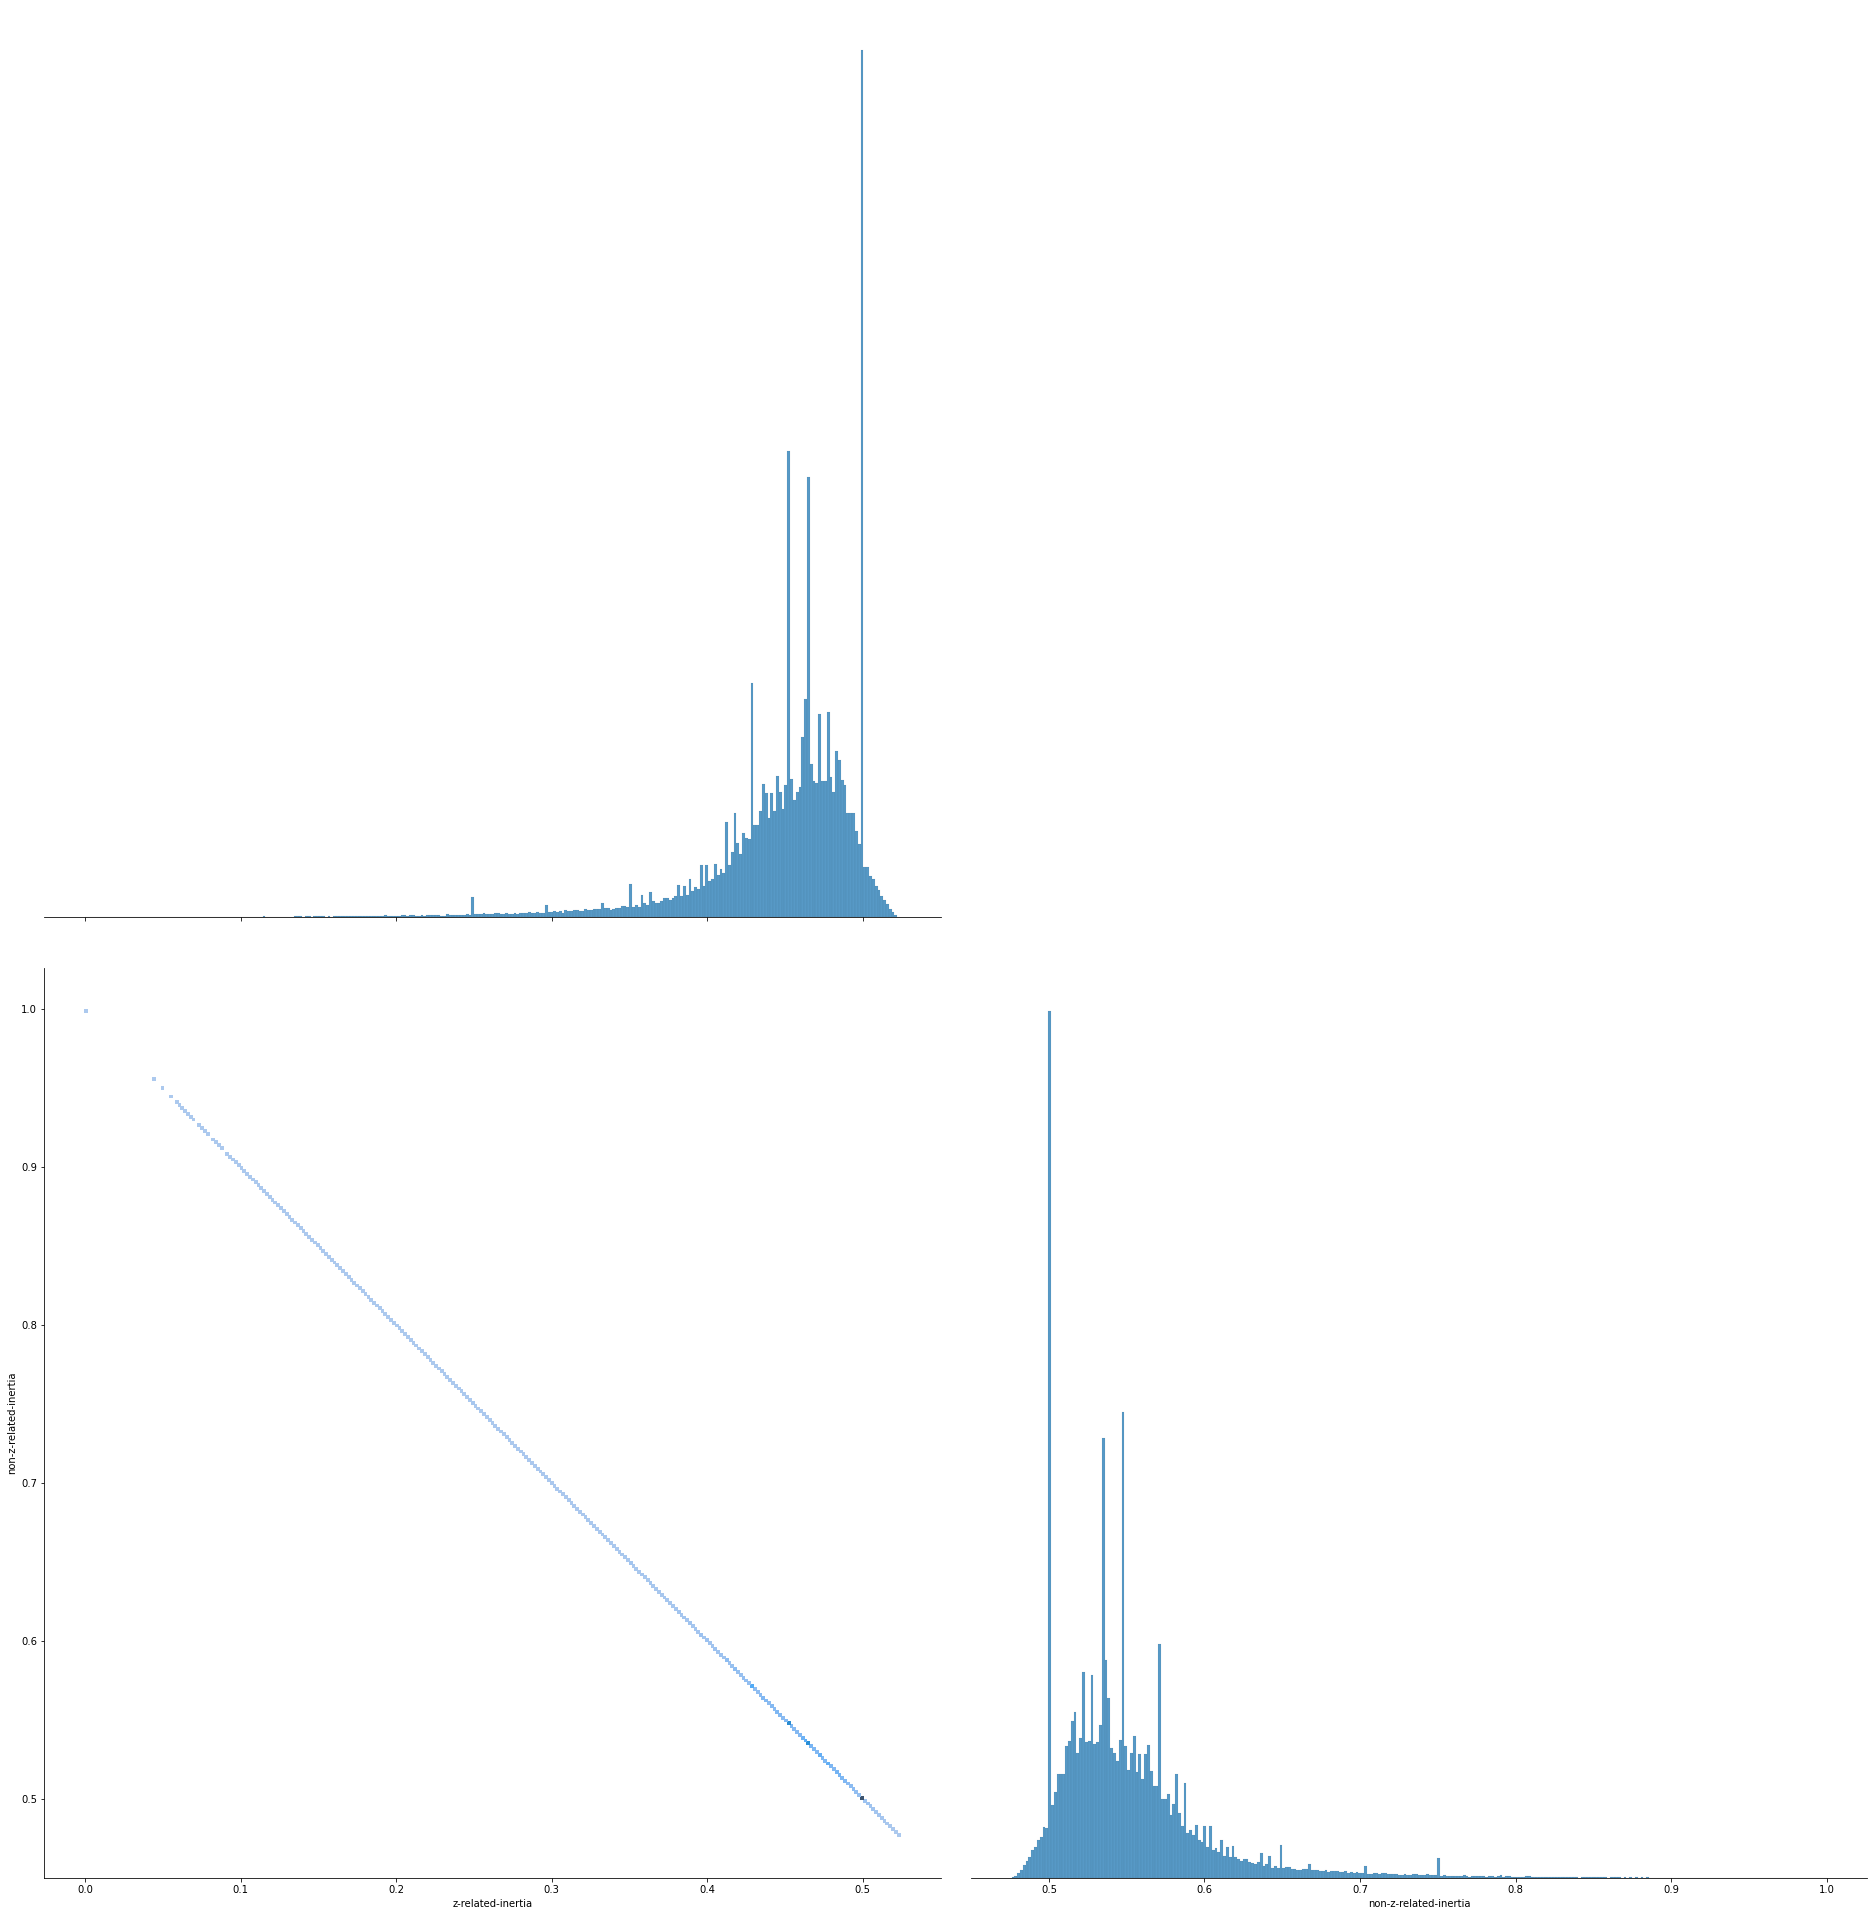

In [160]:
%%time
n = None
df = blobsdf[~blacklist]
df = df.iloc[:n] if n is not None else df
df = df.replace([np.inf, -np.inf], np.nan).dropna()

pairgrid = sns.pairplot(
    df,
    vars=["z-related-inertia", "non-z-related-inertia"],
#     vars=["relative_inertia_tensor-0-0", "relative_inertia_tensor-1-1", "relative_inertia_tensor-2-2", "aspect_ratio"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(False, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 30, sz))

In [165]:
select = (blobsdf["z-related-inertia"] > .525) 
select &= (~blacklist) 
logger.info(f"Found {int(select.sum())} blobs.")
display(blobsdf[select][cols_no_moments_only_diag_inertia])

[2020-11-13::14:37:40.487] tomo2seg :: INFO :: {<ipython-input-165-a1ec626a8fbf>:<module>:003}
Found 4 blobs.



,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,extent,filled_area,centroid-x,centroid-y,centroid-z,local_centroid-x,local_centroid-y,local_centroid-z,inertia_tensor-0-0,inertia_tensor-1-1,inertia_tensor-2-2,major_axis_length,minor_axis_length,id,aspect_ratio,relative_inertia_tensor-0-0,relative_inertia_tensor-1-1,relative_inertia_tensor-2-2
index,,,,,,,,,,,,,,,,,,,,,,,,,,,
4120,2,493,25,102,493,33,172,511,10080,0.04892,493,27,135,501,2.9280,33.900,8.190,376.80,25.140,354.80,77.75,5.617,4121,13.841908,0.764300,0.050994,0.719675
58594,2,74,370,267,1100,373,295,1107,588,0.12590,74,370,281,1104,0.5405,14.664,3.594,64.25,3.652,61.16,32.10,2.713,58595,11.831920,0.868243,0.049351,0.826486
139448,2,2370,718,223,1598,733,359,1633,71400,0.03320,2370,726,295,1613,7.9800,72.400,14.880,1533.00,109.800,1442.00,157.00,13.170,139449,11.921033,0.646835,0.046329,0.608439
256982,2,439,1273,542,1447,1277,610,1462,4080,0.10760,439,1274,574,1454,1.3540,31.770,7.188,341.20,15.560,326.80,73.90,4.426,256983,16.696792,0.777221,0.035444,0.744419


# Save the blacklist

In [15]:
blacklist.sum()

45523

In [16]:
blacklist.shape, blacklist.dtype

((263116,), dtype('bool'))

In [19]:
np.save("blacklist-3d.npy", blacklist.values)